# COVID19

1.参考サイト<br>
 - [Qiita:COVID19](https://qiita.com/tags/covid-19)
 - [Prophetでコロナ陽性者予測をしよう](https://qiita.com/makaishi2/items/aa88ccdc87af3e45edd7)
 
2.準備<br>

In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

3.データの取得
-　厚生労働省のホームページ

https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv

In [2]:
# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format

# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# 乱数の種
random_seed = 123

In [3]:
# 厚生労働省の公開データ
url = 'https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv'
# データ読み込み
df = pd.read_csv(url, parse_dates=[0])
# 結果確認
display(df.head())

,Date,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,Gunma,Saitama,Chiba,Tokyo,Kanagawa,Niigata,Toyama,Ishikawa,Fukui,Yamanashi,Nagano,Gifu,Shizuoka,Aichi,Mie,Shiga,Kyoto,Osaka,Hyogo,Nara,Wakayama,Tottori,Shimane,Okayama,Hiroshima,Yamaguchi,Tokushima,Kagawa,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
0,2020-01-16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2020-01-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2020-01-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2020-01-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2020-01-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
#PREF = 'Toyama'
#PREF_TITLE = '富山県'
PREF = 'Tokyo'
PREF_TITLE = '東京都'
df_pref = df[['Date',PREF]]
df_pref.columns = ['ds', 'y']

In [5]:
df_pref = df_pref[df_pref['ds'] <= dt.datetime(2021,8,28)]
df_tune = df_pref.query('ds >"2021-06-14"')

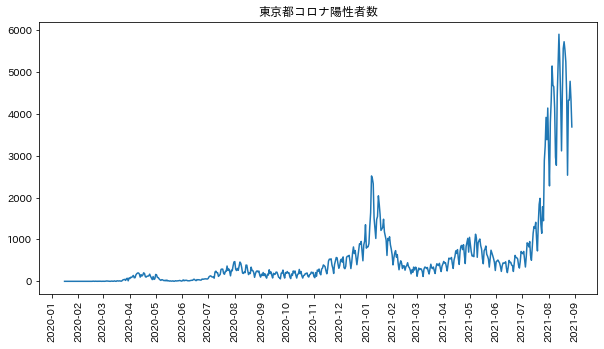

In [6]:
# 時系列グラフの描画 
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(10, 5))

# グラフ描画
ax.plot(df_pref['ds'], df_pref['y'])

# 日付目盛間隔
# 木曜日ごとに目盛りを表示
#weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
# 月ごとに目盛りを表示
months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 方眼表示など
#ax.grid()
ax.set_title(PREF_TITLE + 'コロナ陽性者数')

# 画面出力
plt.show()

In [7]:
import pandas.tseries.offsets as offsets

# 分割日 mdayの設定 (最終日から14日前)
mday = df_pref['ds'].iloc[-1] - offsets.Day(14)

# 訓練用indexと検証用indexを作る
train_index = df_pref['ds'] <= mday
test_index = df_pref['ds'] > mday

# 入力データの分割
x_train = df_pref[train_index]
x_test = df_pref[test_index]

# 日付データの分割(グラフ表示用)
dates_test = df_pref['ds'][test_index]

In [8]:
# ライブラリのimport
from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter
from fbprophet import Prophet

# モデルインスタンス生成
m1 = Prophet(yearly_seasonality=False, weekly_seasonality=True, 
    daily_seasonality=False,
    seasonality_mode='multiplicative')

# 学習
m1.fit(x_train)

ModuleNotFoundError: No module named 'fbprophet'

In [36]:
# 予測用データの作成
future1 = m1.make_future_dataframe(periods=14, freq='D')

# 予測
# 結果はデータフレームで戻ってくる
fcst1 = m1.predict(future1)

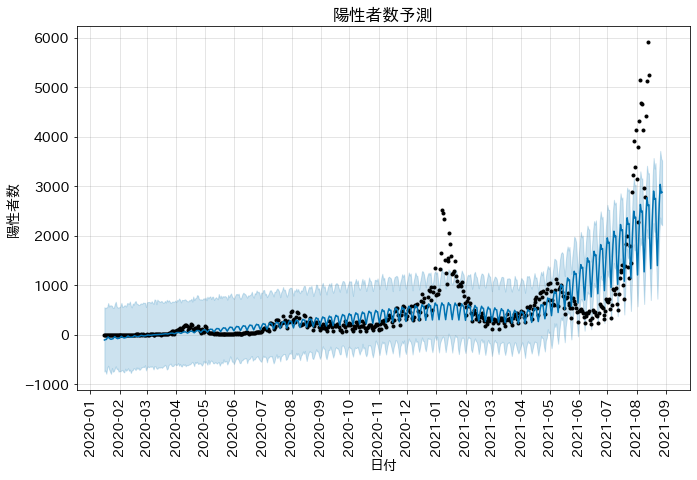

In [37]:
# 訓練データ・検証データ全体のグラフ化
fig, ax = plt.subplots(figsize=(10,6))

# 予測結果のグラフ表示(prophetの関数)
m1.plot(fcst1, ax=ax)
months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# タイトル設定など
ax.set_title('陽性者数予測')
ax.set_xlabel('日付')
ax.set_ylabel('陽性者数')

# グラフ表示
plt.show()

In [89]:
#display(df_tune.tail(15))
# 分割日 mdayの設定 (最終日から14日前)
mday = df_tune['ds'].iloc[-1] - offsets.Day(14)

# 訓練用indexと検証用indexを作る
train_index = df_tune['ds'] < mday
test_index = df_tune['ds'] >= mday

# 入力データの分割
x_train = df_tune[train_index]
x_test = df_tune[test_index]

# 日付データの分割(グラフ表示用)
dates_test = df_tune['ds'][test_index]

display(df_tune.head(5))
display(df_tune.tail(5))

,ds,y
516,2021-06-15,337
517,2021-06-16,500
518,2021-06-17,452
519,2021-06-18,453
520,2021-06-19,388


,ds,y
586,2021-08-24,4328
587,2021-08-25,4334
588,2021-08-26,4783
589,2021-08-27,4350
590,2021-08-28,3691


In [41]:
# モデルインスタンス生成
m2 = Prophet(yearly_seasonality=False, weekly_seasonality=True, 
    daily_seasonality=False,
    seasonality_mode='multiplicative')

# 学習
m2.fit(x_train)

# 予測用データの作成
future2 = m2.make_future_dataframe(periods=9, freq='D')


Initial log joint probability = -26.3914
Iteration  1. Log joint probability =    39.3861. Improved by 65.7775.
Iteration  2. Log joint probability =    74.9276. Improved by 35.5415.
Iteration  3. Log joint probability =    96.4503. Improved by 21.5228.
Iteration  4. Log joint probability =    101.002. Improved by 4.55197.
Iteration  5. Log joint probability =    101.939. Improved by 0.936223.
Iteration  6. Log joint probability =    101.983. Improved by 0.0441431.
Iteration  7. Log joint probability =     101.99. Improved by 0.00719479.
Iteration  8. Log joint probability =    102.164. Improved by 0.17422.
Iteration  9. Log joint probability =    102.179. Improved by 0.0150128.
Iteration 10. Log joint probability =    102.231. Improved by 0.0522306.
Iteration 11. Log joint probability =    102.258. Improved by 0.026227.
Iteration 12. Log joint probability =    102.357. Improved by 0.0990227.
Iteration 13. Log joint probability =    102.407. Improved by 0.0499973.
Iteration 14. Log jo

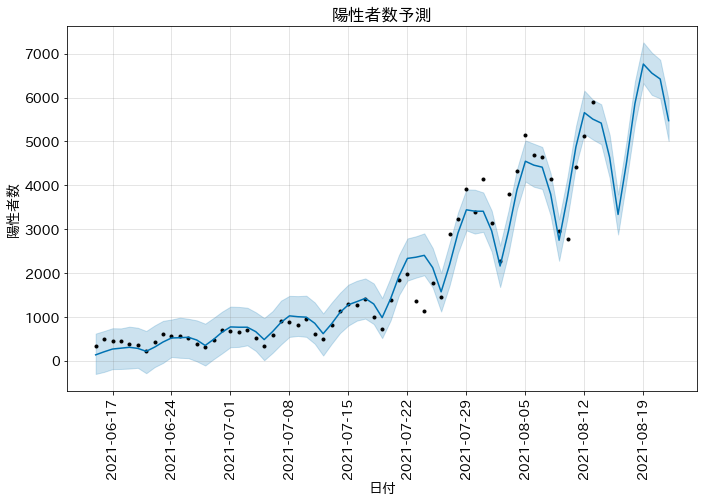

In [42]:
# 予測
# 結果はデータフレームで戻ってくる
fcst2 = m2.predict(future2)

# 訓練データ・検証データ全体のグラフ化
fig, ax = plt.subplots(figsize=(10,6))

# 予測結果のグラフ表示(prophetの関数)
m2.plot(fcst2, ax=ax)
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# タイトル設定など
ax.set_title('陽性者数予測')
ax.set_xlabel('日付')
ax.set_ylabel('陽性者数')

# グラフ表示
plt.show()

In [73]:
# ypred2: fcst1から予測部分のみ抽出する
ypred2 = fcst2[-15:][['yhat']].values

# ytest1: 予測期間中の正解データ
ytest2 = x_test['y'].values

In [83]:
#print(ypred2.shape)
#print(ytest2.shape)
#print(df_pref.shape)
#print(df_tune.shape)
#dates_test
#fcst2.to_csv('../datasets/fcst2.csv')
#x_test.to_csv('../datasets/x_test.csv')
fcst2[-15:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
54,2021-08-08,4112.2530,3310.1275,4271.8970,4112.2530,4112.2530,-0.0759,-0.0759,-0.0759,-0.0759,-0.0759,-0.0759,0.0000,0.0000,0.0000,3800.0376
55,2021-08-09,4241.6296,2282.5993,3226.7277,4241.6296,4241.6296,-0.3515,-0.3515,-0.3515,-0.3515,-0.3515,-0.3515,0.0000,0.0000,0.0000,2750.6457
56,2021-08-10,4371.0062,3258.1010,4196.2286,4371.0062,4371.0062,-0.1440,-0.1440,-0.1440,-0.1440,-0.1440,-0.1440,0.0000,0.0000,0.0000,3741.5611
57,2021-08-11,4500.3828,4446.6875,5347.9174,4500.3828,4500.3828,0.0842,0.0842,0.0842,0.0842,0.0842,0.0842,0.0000,0.0000,0.0000,4879.1548
58,2021-08-12,4629.7594,5173.6610,6156.7959,4629.7594,4629.7594,0.2216,0.2216,0.2216,0.2216,0.2216,0.2216,0.0000,0.0000,0.0000,5655.7116
59,2021-08-13,4759.1360,5044.9571,5951.0621,4759.1360,4759.1360,0.1575,0.1575,0.1575,0.1575,0.1575,0.1575,0.0000,0.0000,0.0000,5508.4782
60,2021-08-14,4888.5126,4935.5883,5845.5293,4887.9289,4889.5170,0.1082,0.1082,0.1082,0.1082,0.1082,0.1082,0.0000,0.0000,0.0000,5417.5601
61,2021-08-15,5017.8892,4171.0385,5149.9665,5014.1659,5022.9491,-0.0759,-0.0759,-0.0759,-0.0759,-0.0759,-0.0759,0.0000,0.0000,0.0000,4636.9150
62,2021-08-16,5147.2658,2881.4259,3792.7678,5138.3701,5158.0587,-0.3515,-0.3515,-0.3515,-0.3515,-0.3515,-0.3515,0.0000,0.0000,0.0000,3337.9399
63,2021-08-17,5276.6424,4100.5950,5000.6487,5260.2479,5294.3518,-0.1440,-0.1440,-0.1440,-0.1440,-0.1440,-0.1440,0.0000,0.0000,0.0000,4516.7816


,ds,y
576,2021-08-14,5249
577,2021-08-15,4358
578,2021-08-16,3119
579,2021-08-17,4534
580,2021-08-18,5567
581,2021-08-19,5729
582,2021-08-20,5529
583,2021-08-21,5247
584,2021-08-22,4448
585,2021-08-23,2537


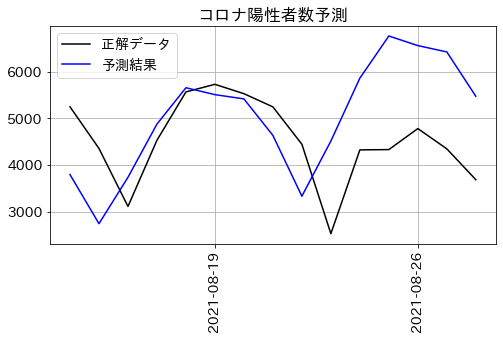

In [75]:
# 時系列グラフの描画 
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# グラフ描画
ax.plot(dates_test, ytest2, label='正解データ', c='k')
ax.plot(dates_test, ypred2, label='予測結果', c='b')

# 日付目盛間隔
# 木曜日ごとに日付を表示
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 方眼表示など
ax.grid()
ax.legend()
ax.set_title('コロナ陽性者数予測')

# 画面出力
plt.show()

In [ ]:
# 祝日データ取得
url2 = 'https://raw.githubusercontent.com/holiday-jp/holiday_jp/master/holidays.yml'
df5 = pd.read_csv(url2, sep=':\s+', parse_dates=[0],names=['日付','祝日名'])
df5 = df5[1:]

In [ ]:
# 2020-2021に絞り込み
df5 = df5.query('日付>"2019-12-31" & 日付<"2021-12-31"')